# Introduction
This notebook will handle a denoising autoencoder on the MNIST-dataset.

The specifics of autoencoding are in the fact that there is no label needed to predict as it is known in common deep-learning architecture. Under this particular architecture, the goal is to "predict" its given input values (the features). Therefore we better say "reconstruct" instead of "predict". The model is forced to reconstruct the the given features, this is implemented through three major changes to the traditional NN structure:
1. Building the model out of two seperate models (encoder and decorder).
2. Reducing the given information in the middle of the network (codings).
3. Using the features as label values as well (prediction value is the input).

You will find these structures as well as two variations of denoising autoencoders in this notebook, one with a simple deep neural network (Deep Denoising Autoencoder) and a dropout layer and another one (Convolutional Denoising Autoencoder) with convolution layers and a GaussianNoise creation.

## My other Projects
If you are interested in some more clearly analysis of the dataset, take a look into my other notebooks about the MNIS-dataset:

- cnn-for-digit-recognition-MNIST (accuracy score: 0.99135):
    - https://www.kaggle.com/skiplik/cnn-for-digit-recognition-mnist 
- Finetuning Hyperparameters in Deep Neural Network:
    - https://www.kaggle.com/skiplik/finetuning-hyperparameters-in-deep-neural-network
- Digit Recognition with a Deep Neural Network:
    - https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network
- Another MNIST Try:
    - https://www.kaggle.com/skiplik/another-mnist-try
- First NN by Detecting Handwritten Characters:
    - https://www.kaggle.com/skiplik/first-nn-by-detecting-handwritten-characters 
- ...

# Imports

In [1]:
import sys
assert sys.version_info >= (3,5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers

import mlflow
from mlflow import log_metric, log_param, log_artifacts
import mlflow.tensorflow
from mlflow import pyfunc

assert tf.__version__ >= "2.0"

print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ",keras.__version__)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


tf.random.set_seed(42)
np.random.seed(42)
random_state=42

kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../autoencoding-mnist/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version:  2.3.0
Keras Version:  2.4.0
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\keras_reg_jl_160_10_002.sav
../autoencoding-mnist/data/input/digit-recognizer\sample_submission.csv
../autoencoding-mnist/data/input/digit-recognizer\test.csv
../autoencoding-mnist/data/input/digit-recognizer\train.csv


## Get The Data

In [2]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_csv_data(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path)

def load_csv_data_manuel(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data
    

train = load_csv_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_csv_data(MNIST_PATH,CSV_FILE_TEST)

### Train Val Split

In [3]:
X_train, X_valid, y_train, y_valid =  train_test_split(train.loc[:, train.columns != 'label'], train['label'], test_size=0.33, random_state=random_state)

### Preparing for Neural Network Structure

In [4]:
X_train = X_train.astype(np.float32) / 255
X_valid = X_valid.astype(np.float32) / 255
X_test = test.astype(np.float32) / 255

In [5]:
print(f'"X_train" shape: {X_train.shape}')
print(f'"X_valid" shape: {X_valid.shape}')
print(f'"X_test" shape: {X_test.shape}')

"X_train" shape: (28140, 784)
"X_valid" shape: (13860, 784)
"X_test" shape: (28000, 784)


#### Reshaping Data in Tensor Batch Structure

In [6]:
def reshape_images(df_images):
    df_images_resh = df_images.values.reshape(df_images.shape[0], 28, 28)
    return df_images_resh

def reshape_conv_images(df_images):
    df_images_conv_resh = df_images.values.reshape(df_images.shape[0], 28, 28, 1)
    return df_images_conv_resh

In [7]:
##### TODO: reshape_images() einbauen 
X_train_resh = X_train.values.reshape(X_train.shape[0], 28, 28)
X_valid_resh = X_valid.values.reshape(X_valid.shape[0], 28, 28)

y_train_resh =  y_train.values.reshape(y_train.shape[0], 1)
y_valid_resh = y_valid.values.reshape(y_valid.shape[0], 1)

In [8]:
print(f'"X_train_resh" shape: {X_train_resh.shape}')
print(f'"X_valid_resh" shape: {X_valid_resh.shape}')
print(f'"y_train_resh" shape: {y_train_resh.shape}')
print(f'"y_valid_resh" shape: {y_valid_resh.shape}')

"X_train_resh" shape: (28140, 28, 28)
"X_valid_resh" shape: (13860, 28, 28)
"y_train_resh" shape: (28140, 1)
"y_valid_resh" shape: (13860, 1)


# Plotting 

In [9]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, X_valid, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

### Plotting One Example Value

In [10]:
print(f'Example label: {y_valid.iloc[1]}')

Example label: 1


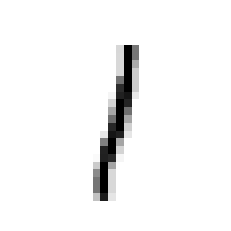

In [11]:
plot_image(X_valid.iloc[1].values.reshape(28,28))

# First Model - Deep Denoising Autoencoder 
An autoencoder architecture includes two seperate models, the encoder and the decorder. In the neuron point of view they both have a rejuvenation which represents a need of information compression - keep only the realy relevant information and drop the less relevant information. The encoder has an input of 784 neurons and an output of only 30 (which represents the codings). On the otherside the decoder has an inputshape of 30 neurons with an layer of 100 neurons, which rises to an layer of 28 * 28 neurons (=784) again. 

These two models combined bring the need of reducing given information and (artificially) recreating them again. Thats the specialty of the autoencoder structure.

### Encoder Architecture

In [12]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")           # Codings
])

In [13]:
dropout_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


#### Decoder Architecture

In [14]:
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),  ### PROBLEM AREA found: USE THE RIGHT ACTIVATION FUNCTION
    keras.layers.Reshape([28, 28])
])

In [15]:
dropout_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


### Building the Model

In [16]:
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))

## Training and Logging -  Deep Denoising Autoencoder

### Logging the Model (ML Flow)

In [17]:
#mlflow.tensorflow.autolog()

### Training the Model

In [18]:
history = dropout_ae.fit(X_train_resh, X_train_resh, epochs= 10, validation_data=(X_valid_resh, X_valid_resh))


Epoch 1/10
880/880 [==============================] - 2s 2ms/step - loss: 0.2242 - val_loss: 0.1742
Epoch 2/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1679 - val_loss: 0.1491
Epoch 3/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1543 - val_loss: 0.1407
Epoch 4/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1480 - val_loss: 0.1339
Epoch 5/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1436 - val_loss: 0.1312
Epoch 6/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1406 - val_loss: 0.1311
Epoch 7/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1379 - val_loss: 0.1278
Epoch 8/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1356 - val_loss: 0.1261
Epoch 9/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1337 - val_loss: 0.1223
Epoch 10/10
880/880 [==============================] - 1s 2ms/step - loss: 0.1321 - val_loss: 0.1204

### Losses
The question is: "How good does the model reconstruct the given features/information". So there is no prediction of some label value! The model "predicts" (or better) reconstruct its input values to its best

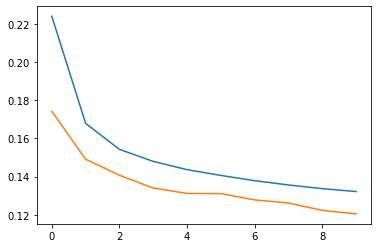

In [19]:
# Getting in touch with the model statistics 
# shows the available keys in models history:  print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Second Model - Convolutional Denoising Autoencoder 

### Convolutional Encoder Architecture  

In [20]:
conv_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape = [28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=4),
    keras.layers.Dense(392, activation="relu")           # Codings
])

In [21]:
conv_encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 3, 3, 392)         12936     
Total params: 17,736
Trainable params: 17,736
Non-trainable params: 0
__________________________________________________

### Convolutional Decoder Architecture

In [22]:
conv_decoder = keras.models.Sequential([
    #keras.layers.GaussianNoise(0.1, input_shape=[6, 6, 32] ),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",activation="selu", input_shape=[3, 3, 392]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28, 1])
])

In [23]:
conv_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          112928    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 117,697
Trainable params: 117,697
Non-trainable params: 0
_________________________________________________________________


### Building the Model - Deep Convolutional Denoising Autoencoder

In [24]:
conv_denoising_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))

In [25]:
conv_denoising_ae.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 3, 3, 392)         17736     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         117697    
Total params: 135,433
Trainable params: 135,433
Non-trainable params: 0
_________________________________________________________________


## Training and Logging - Deep Convolutional Denoising Autoencoder

### Training the Model

In [26]:
X_train_resh_ch = X_train_resh.reshape(X_train_resh.shape[0], 28 ,28 ,1)
X_valid_resh_ch = X_valid_resh.reshape(X_valid_resh.shape[0], 28 ,28 ,1)

In [27]:
history = conv_denoising_ae.fit(X_train_resh_ch, X_train_resh_ch, epochs= 10, validation_data=(X_valid_resh_ch, X_valid_resh_ch))


Epoch 1/10
880/880 [==============================] - 10s 12ms/step - loss: 0.1842 - val_loss: 0.1113
Epoch 2/10
880/880 [==============================] - 10s 11ms/step - loss: 0.1075 - val_loss: 0.1000
Epoch 3/10
880/880 [==============================] - 10s 11ms/step - loss: 0.0982 - val_loss: 0.0936
Epoch 4/10
880/880 [==============================] - 10s 12ms/step - loss: 0.0935 - val_loss: 0.0921
Epoch 5/10
880/880 [==============================] - 10s 12ms/step - loss: 0.0909 - val_loss: 0.0884
Epoch 6/10
877/880 [============================>.] - ETA: 0s - loss: 0.0889

KeyboardInterrupt: 

# Results - Deep Denoising Autoencoder

## Real Image

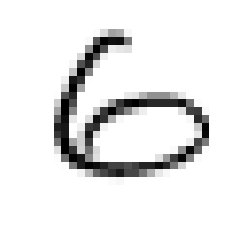

In [ ]:
# Test image from a known set
plot_image(X_valid_resh[10])

## ("Predicted") Reconstructed One

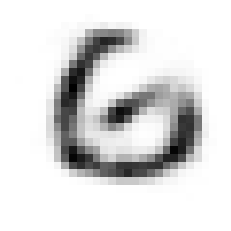

In [ ]:
testimage = X_valid_resh[10].reshape(1, 28, 28)     # single image prepared for the test (reshape)
plot_image(dropout_ae.predict(testimage)[0, :, :])  # needed to extract the second and third array of the three dimensional tensor struc for printing the image

## Showing Multi Results

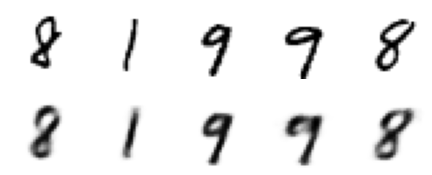

In [ ]:
show_reconstructions(dropout_ae, X_valid_resh)

## Using Noised Images

### Creating Noisy Data


In [ ]:
new_images = X_test[5:10]
new_images = reshape_images(new_images)
noisy_images = new_images + np.random.randn(5,28,28) *0.1

### Origin Number


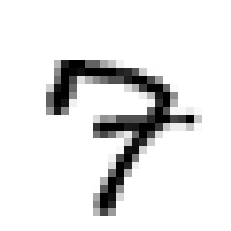

In [ ]:
idx_testnumber = 0      # Index of test number for the next plottings 
plot_image(new_images[idx_testnumber])

### Noisy Number

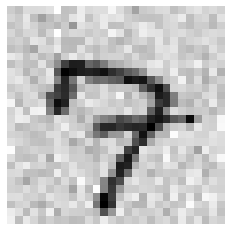

In [ ]:
plot_image(noisy_images[idx_testnumber])

### Denoised Number

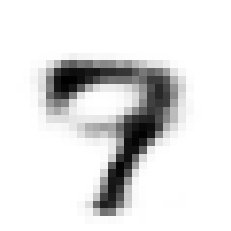

In [ ]:
# Very Important ! added a new axis according to the models batch based behavior
plot_image(dropout_ae.predict(noisy_images[np.newaxis ,idx_testnumber]).reshape(28,28)) 

### Multiple Numbers in Comparision 

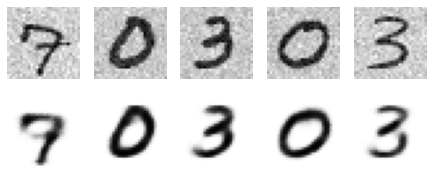

In [ ]:
show_reconstructions(dropout_ae, noisy_images)

# Results - Convolutional Denoising Autoencoder

## Using Noised Images

### Creating Noisy Data

In [ ]:
new_images_conv = X_test[5:10]
new_images_conv = reshape_conv_images(new_images_conv)
noisy_images_conv = new_images_conv + np.random.randn(5, 28, 28, 1) *0.1

In [ ]:
noisy_images_conv.shape

(5, 28, 28, 1)

### Origin Number


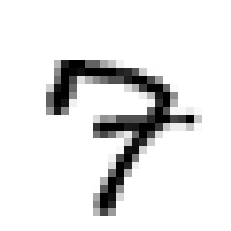

In [ ]:
idx_testnumber = 0      # Index of test number for the next plottings 
plot_image(new_images_conv[idx_testnumber])

### Noisy Number

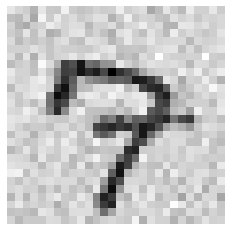

In [ ]:
plot_image(noisy_images_conv[idx_testnumber])

### Denoised Number

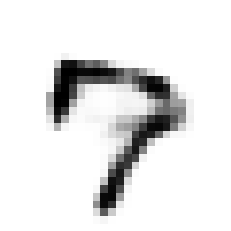

In [ ]:
# Very Important ! added a new axis according to the models batch based behavior
plot_image(conv_denoising_ae.predict(noisy_images_conv[np.newaxis ,idx_testnumber]).reshape(28,28))

### Multiple Numbers in Comparision

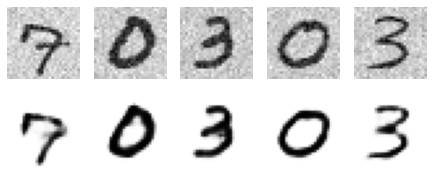

In [ ]:
show_reconstructions(conv_denoising_ae, noisy_images_conv)

# Unsupervised Pre-Training for Supervised Training
In this part I will use the first layers of the already trained autoencoder for implementing a classification prediction model. This architecture represents the way of using unsupervised pre-training for projects that do not have enough training data to train the final model (in this case the classification model).


##################################

Beim unüberwachten Vortrainieren wird ein Modell mit den ungelabelten Daten (oder allen Daten) mithilfe einer unüberwachten Lerntechnik trainiert und dann für die eigentliche Aufgabe mit den gelabelten Aufgaben mit einer überwachten Lerntechnik im Detail angepasst – der unüberwachte Teil kann wie hier gezeigt eine Schicht nach der anderen oder direkt das ganze Modell trainieren.



In [ ]:
# Debug
#conv_den_ae_layes = 
conv_denoising_ae.layers[0].layers

In [ ]:
##### DEBUG - TODELETE
# Extracting the trained lower layers of the autoencoder
denoising_ae_l_layers = dropout_ae.layers[0].layers
print("Layers from the autoencoder that will be used for new model: ")
denoising_ae_l_layers[:5]

Layers from the autoencoder that will be used for new model: 


In [ ]:
ae_model_id = 0 # 0 for encorder / 1 for decorder
layerscount = 4 # how many layers of the model ...

conv_denoising_ae.layers[ae_model_id].trainable =True       # Sets all layers on trainable = True for specific non-trainable configuration in later code.

first_layers = [conv_denoising_ae.layers[ae_model_id].get_layer(index=index) for index in range(layerscount)] # is copy here necessary 

In [ ]:
first_layers

In [ ]:
# creating a new layer list for the new model and make the layers not trainable
new_layers = first_layers
for layer in new_layers[:layerscount - 1]:              # last layer still be trainable
    layer.trainable = False
    print(f"Layer '{layer.name}' is Trainable = {layer.trainable}")

Layer 'gaussian_noise' is Trainable = False
Layer 'conv2d' is Trainable = False
Layer 'max_pooling2d' is Trainable = False


In [ ]:
# Debug
new_layers[0].input

<tf.Tensor 'gaussian_noise_input:0' shape=(None, 28, 28, 1) dtype=float32>

In [ ]:
new_layers[3].output_shape


(None, 13, 13, 32)

In [ ]:
new_layers.append(keras.layers.Flatten())         ### DEBUG TODO: is Flatten necessary
# Adding the final layer (outputlayer)
new_layers.append(keras.layers.Dense(10, activation=keras.activations.softmax))

In [ ]:
# Viewing final layers-construction
for layer in new_layers:
    print(f"Layer '{layer.name}' trainable state = {layer.trainable}")

Layer 'gaussian_noise' trainable state = False
Layer 'conv2d' trainable state = False
Layer 'max_pooling2d' trainable state = False
Layer 'conv2d_1' trainable state = True
Layer 'flatten_5' trainable state = True
Layer 'dense_13' trainable state = True


In [ ]:
class_net = keras.models.Sequential(
    new_layers
)

In [ ]:
class_net.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=["mse"])  ### DEBUG TODO: changed optimizer from nadam() to keras.optimizers.SGD(learning_rate=1.0)
#class_net.build(input_shape= [28, 28, 1])
# (loss="categorical_crossentropy", optimizer="adam", metrics=['categorical_accuracy'])

#loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(), metrics=["mse"]

In [ ]:
class_net.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
flatten_5 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                54090     
Total params: 58,890
Trainable params: 58,730
Non-trainable params: 160
_______________________________________________

In [ ]:
# DEBUG -> HIER weiter analysieren
print(f"Layer: {class_net.get_layer(index=1).name} output shape: {class_net.get_layer(index=1).output_shape}")
print(f"Layer: {class_net.get_layer(index=2).name} input shape: {class_net.get_layer(index=2).input_shape}")
print(f"Layer: {class_net.get_layer(index=2).name} output shape: {class_net.get_layer(index=2).output_shape}")
print(f"Layer: {class_net.get_layer(index=3).name} input shape: {class_net.get_layer(index=3).input_shape}")
print(f"Layer: {class_net.get_layer(index=3).name} output shape: {class_net.get_layer(index=3).output_shape}")
print(f"Layer: {class_net.get_layer(index=4).name} input shape: {class_net.get_layer(index=4).input_shape}")
print(f"Layer: {class_net.get_layer(index=4).name} output shape: {class_net.get_layer(index=4).output_shape} with activation function: {class_net.get_layer(index=4).activation}")
#print(f"Layer: {class_net.get_layer(index=5).name} input shape: {class_net.get_layer(index=5).input_shape}")
#print(f"Layer: {class_net.get_layer(index=5).name} output shape: {class_net.get_layer(index=5).output_shape} with activation function: {class_net.get_layer(index=5).activation}")

#class_net.get_layer(index=5).input_shape

Layer: conv2d output shape: (None, 26, 26, 16)
Layer: max_pooling2d input shape: (None, 26, 26, 16)
Layer: max_pooling2d output shape: (None, 13, 13, 16)
Layer: conv2d_1 input shape: (None, 13, 13, 16)
Layer: conv2d_1 output shape: (None, 13, 13, 32)
Layer: flatten_5 input shape: (None, 13, 13, 32)


AttributeError: 'Flatten' object has no attribute 'activation'

## Creating Training Data for Unsupervised Pre-Training Model
In this part 500 training data sets will be created for training a normal backpropagation model based on the unsupervised pre-trained model.

In [ ]:
X_train_pretrained_500 = X_train_resh[:500]
X_valid_pretrained_500 = X_valid_resh[:500]

y_train_pretrained_500 = y_train_resh[:500]
y_valid_pretrained_500 = y_valid_resh[:500]

# reshaping for conv model structure (batchsize, pixel h, pixel w, channel)
X_train_pret_resh_500 = X_train_pretrained_500.reshape(X_train_pretrained_500.shape[0],X_train_pretrained_500.shape[1], X_train_pretrained_500.shape[2], 1)
X_valid_pret_resh_500 = X_valid_pretrained_500.reshape(X_valid_pretrained_500.shape[0],X_valid_pretrained_500.shape[1], X_valid_pretrained_500.shape[2], 1)

In [ ]:
print(X_train_pret_resh_500.shape)
print(X_valid_pret_resh_500.shape)
print(y_train_pretrained_500.shape)
print(y_valid_pretrained_500.shape)



(500, 28, 28, 1)
(500, 28, 28, 1)
(500, 1)
(500, 1)


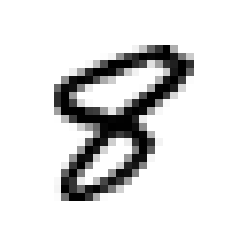

In [ ]:
plot_image(X_train_pret_resh_500[499])

In [ ]:
X_train_pret_resh_500[0:10].shape

(10, 28, 28, 1)

In [ ]:
y_train_pretrained_500[0:5].shape

(5, 1)

In [224]:
# validation_data=(X_valid_pretrained_500, y_valid_pretrained_500)


## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  Fehler liegt irgendwo in der Modelarchitecktur begraben. Irgendwo zwischen vorletzten und letzten Layer 
#
## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


history_pretrainted = class_net.fit(X_train_pret_resh_500,y_train_pretrained_500 ,epochs= 150, validation_data=[X_valid_pret_resh_500,y_valid_pretrained_500])


Epoch 1/150
16/16 [==============================] - 0s 8ms/step - loss: 10.7890 - mse: 29.3770 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/150
16/16 [==============================] - 0s 5ms/step - loss: 10.6127 - mse: 29.3763 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 3/150
16/16 [==============================] - 0s 5ms/step - loss: 10.5741 - mse: 29.3761 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 4/150
16/16 [==============================] - 0s 5ms/step - loss: 10.5312 - mse: 29.3759 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 5/150
16/16 [==============================] - 0s 5ms/step - loss: 10.5340 - mse: 29.3759 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 6/150
16/16 [==============================] - 0s 5ms/step - loss: 10.5336 - mse: 29.3759 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 7/150
16/16 [==============================] - 0s 5ms/step - loss: 10.5298 - mse: 29.3759 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 8/150
1

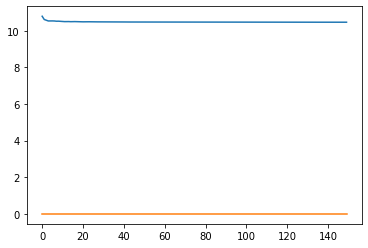

In [225]:
plt.plot(history_pretrainted.history['loss'])
plt.plot(history_pretrainted.history['val_loss'])

### Predicting the Digits on a Pre-Trained Autoencoder based Model

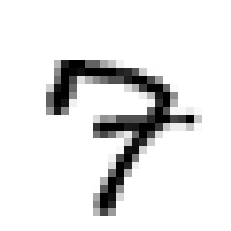

In [226]:
idx_testnumber_cls_ae = 0      # Index of test number for the next plottings 
plot_image(new_images[idx_testnumber_cls_ae])

In [227]:
# Predicting the correct number based on the trained model. 
print("The predicted digit: ", np.argmax(class_net.predict(new_images[np.newaxis, idx_testnumber_cls_ae])))
print("Probability of the Prediction: ", class_net.predict(new_images[np.newaxis, idx_testnumber_cls_ae]))


The predicted digit:  8
Probability of the Prediction:  [[0.10179814 0.09892005 0.10118096 0.09706689 0.09634113 0.09915446
  0.10205372 0.09792157 0.10467499 0.10088812]]
